In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import fmin_bfgs
from tqdm import tqdm_notebook,tqdm

import matplotlib.pyplot as plt

# custom percentile function to exactly replicate matlab
def quantile(x,q):
    n = len(x)
    y = np.sort(x)
    return(np.interp(q, np.linspace(1/(2*n), (2*n-1)/(2*n), n), y))

def prctile(x,p):
    return(quantile(x,np.array(p)/100))
# discussion: https://stackoverflow.com/questions/24764966/numpy-percentile-function-different-from-matlabs-percentile-function

In [109]:
# load GKX data 
data_stocks_dir = '/Users/Sally/Desktop/Summer Term/BD2/coursework2/'
micro = pd.read_pickle(data_stocks_dir + 'returns_chars_panel_raw.pkl') # use dropbox links to download this
macro = pd.read_pickle(data_stocks_dir + 'macro_timeseries.pkl')
df = pd.merge(micro,macro,on='date',how='left',suffixes=['','_macro']) # include macro predictors

In [24]:
df

,date,permno,excess_ret,ret,rfree,mvel1,beta,betasq,chmom,dolvol,...,ep_macro,b/m,crsp_spvw,svar,tbl,tms,dfy,dfr,ntis,infl
0,1986-02-01,10000,-0.262610,-0.257143,0.005467,1.610000e+04,NaN,NaN,NaN,NaN,...,-2.675897,0.583517,0.004706,0.001920,0.0707,0.0251,0.0139,0.0070,-0.019172,0.002745
1,1986-03-01,10000,0.360335,0.365385,0.005050,1.196000e+04,NaN,NaN,NaN,NaN,...,-2.747007,0.536377,0.076525,0.001089,0.0706,0.0135,0.0144,-0.0393,-0.017914,-0.002737
2,1986-04-01,10000,-0.103717,-0.098592,0.005125,1.633000e+04,NaN,NaN,NaN,7.897668,...,-2.800518,0.519628,0.055832,0.001374,0.0656,0.0110,0.0150,-0.0514,-0.016420,-0.004575
3,1986-05-01,10000,-0.227831,-0.222656,0.005175,1.517200e+04,NaN,NaN,NaN,8.472954,...,-2.781919,0.529714,-0.013348,0.002459,0.0606,0.0176,0.0140,0.0096,-0.024585,-0.001838
4,1986-06-01,10000,-0.009883,-0.005025,0.004858,1.179386e+04,NaN,NaN,NaN,8.250098,...,-2.826589,0.503541,0.055326,0.001370,0.0615,0.0233,0.0120,0.0341,-0.021872,0.002762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3739444,2016-08-01,93436,-0.097265,-0.097023,0.000242,3.491163e+07,1.600823,2.562634,0.509589,18.685227,...,-3.210865,0.314661,0.036571,0.000478,0.0030,0.0145,0.0094,0.0164,-0.031614,-0.001618
3739445,2016-09-01,93436,-0.037915,-0.037640,0.000275,3.164016e+07,1.636403,2.677816,0.334004,18.492052,...,-3.201425,0.315197,0.001247,0.000279,0.0030,0.0156,0.0092,0.0156,-0.030723,0.000918
3739446,2016-10-01,93436,-0.031253,-0.030878,0.000375,3.056879e+07,1.633774,2.669218,-0.037025,18.518768,...,-3.192038,0.316794,0.000446,0.001673,0.0029,0.0167,0.0090,0.0005,-0.032543,0.002404
3739447,2016-11-01,93436,-0.042553,-0.042128,0.000425,2.963795e+07,1.614461,2.606485,-0.342211,18.641207,...,-3.152198,0.319688,-0.017958,0.000364,0.0033,0.0187,0.0087,0.0051,-0.028976,0.001247


# Find More Influential Stock Characteristics

In the last coursework, we implemented the neural network prediction on the stock returns. With all 94 stock characteristics tested, the first methedology calculates the decrease in OOS R² with decreasing a variable at a time, and the chart below listed out the top 10 most influential variables:




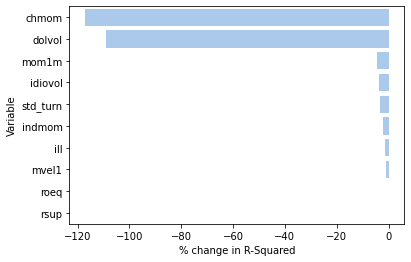

The second approach measures how sensitive the prediction to change if we change the tested variable. And the chart below lists top 10 variables with greatest sensitivity:
 


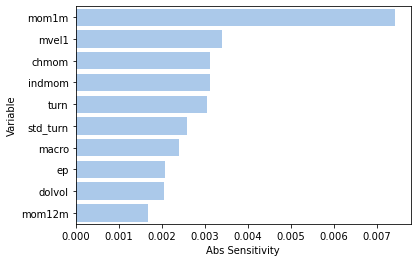

Comparing the 2 charts , we can see various momentum variables and trading volumes have strong interpretive power in measuring the stock returns. This makes sense all those variables are highly related to the market volatility, we think adding those variables to our policy may have positive influence in our results. Because it will help us better capture the momentum anomolies and maximize the utilities in the end:

<br> oroginal: mvel1, bm, mom12m
<br>mom1m: 1-month momentum
<br>chmom:  change in 6-month momentum
<br>dolvol: natural log of trading volume times price per share from month t-2 
<br>indmom: industry momentum 
<br>std_turn: volatility of share turnover


**Create Benchmark -- S&P500**

In [4]:
import tqdm

n_train = 360
dt = pd.DataFrame()


for year in tqdm.tqdm(range(1974,2016)): # using data from 1974 as in BSV, but longer sample
    for month in range(1,13):
        dta = df[(df['date'].dt.year==year) & (df['date'].dt.month==month)] 
        dt = dt.append(dta.head(1),ignore_index=True)
dt_date = dt['date']

dt_date_train = dt_date[0:n_train]
dt_date_test = dt_date[n_train:]

100%|██████████| 42/42 [02:18<00:00,  3.30s/it]


In [7]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
SPY_data = pdr.get_data_yahoo("SPY",start = '2003-12-01', end= '2015-12-02')
SPY_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01,106.849998,107.680000,106.800003,107.599998,75.357986,38699000
2003-12-02,107.379997,107.769997,107.070000,107.330002,75.168900,35352000
2003-12-03,107.650002,108.080002,107.070000,107.160004,75.049828,39078600
2003-12-04,107.169998,107.720001,106.940002,107.599998,75.357986,36089500
2003-12-05,107.120003,107.800003,106.620003,106.849998,74.832703,28824400
...,...,...,...,...,...,...
2015-11-24,207.869995,209.830002,207.410004,209.350006,186.466690,98874400
2015-11-25,209.500000,209.740005,209.009995,209.320007,186.439972,51980100
2015-11-27,209.429993,209.800003,208.860001,209.559998,186.653702,37317800


<AxesSubplot:xlabel='date'>

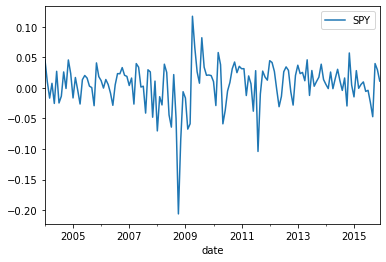

In [10]:
#calculate monthly average of the data 
SPY_data_mo = SPY_data.groupby(pd.Grouper( freq='M'))['Close'].mean()
SPY_rtn = SPY_data_mo.pct_change(1).iloc[1:]


#create return dataframe
rtn_p = dt_date_test.to_frame()
rtn_p['SPY'] = SPY_rtn.array
rtn_p.plot(x='date',y=['SPY'])

# Policy Gradient with Linear Model

**Define the Linear Model Policy Functions**

In [112]:
# policy function
def policy(theta,x,wm):
    theta_ = theta.reshape(-1,1) 
    w = []
    for t in range(len(x)):
        w.append(wm[t] + np.matmul(x[t],theta_) / len(wm[t])) # portfolio weight
    return w

# value function
def value(ret,w,gamma=5):
    u = []
    for t in range(len(ret)):
        retp = np.sum(w[t]*ret[t]) # portfolio return
        if gamma == 1:
            u.append(np.log(1+retp))
        else:
            u.append((1+retp)**(1-gamma) / (1-gamma))
    return np.mean(u)

def portfolio_returns(ret,w):
    retps = []
    for t in range(len(ret)):
        retp = np.sum(w[t]*ret[t]) # portfolio return
        retps.append(retp)
    return np.array(retps)

# analytical gradient 
def grad(theta,w,x,wm,ret,gamma=5):
    grads = []
    for t in range(len(ret)):
        retp = np.sum(w[t]*ret[t]) 
        m = (1+retp)**(-gamma)
        z = m * ret[t] / len(ret[t])
        grads.append(np.matmul(z.T,x[t]))
    return np.mean(np.vstack(grads),axis=0)

# check analytical versus numerical gradient -- if this yields <1e-4 we are ok
def grad_check(theta,w,x,wm,ret,h=1e-5):
    dtheta_num = []
    for i in range(len(theta)):
        h_vec = np.zeros_like(theta) # perturb in direction i
        h_vec[i] = h
        up = value(ret,policy(theta + h_vec,x,wm))
        down = value(ret,policy(theta - h_vec,x,wm))
        dtheta_num.append((up - down) / (2*h)) # numerical grad
    
    dtheta = grad(theta,w,x,wm,ret)
    return np.abs(dtheta-dtheta_num) / np.maximum(dtheta,dtheta_num)



**Linear Model 1 -- With 3 Factors: mvel1, btm, mom 12m**

100%|██████████| 42/42 [02:30<00:00,  3.58s/it]


Text(0, 0.5, 'number of stocks')

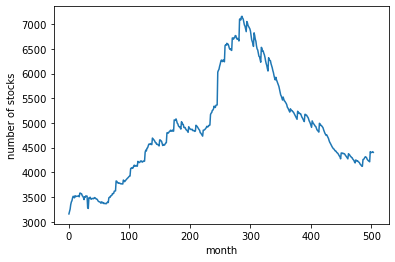

In [113]:
from tqdm import tqdm

# clean data
wm,x,ret,rf = [],[],[],[] # lists holding data for each period
mean_chars = [] # for debug
for year in tqdm(range(1974,2016)): # using data from 1974 as in BSV, but longer sample
    for month in range(1,13):
        dta = df[(df['date'].dt.year==year) & (df['date'].dt.month==month)] # data for this period
        
        cols = ['mvel1','bm','mom12m','ret','rfree']
        dta = dta[cols].dropna()
                
        # cleaning: remove size below 0.2 percentile and negative beme
        min_me = prctile(dta['mvel1'],0.2)
        dta = dta[(dta['mvel1']>=min_me) & (dta['bm']>=0)]
        
        # get value weights for bsv policy
        mv = dta['mvel1'].values.reshape(-1,1)
        wm.append(mv/np.sum(mv))
        
        # get normalised characteristics for policy
        sz = np.log(dta['mvel1'])
        btm = np.log(1+dta['bm'])
        mom = dta['mom12m']
        char = np.vstack([sz,btm,mom]).T
        mean_chars.append(np.mean(char,axis=0))
        char -= np.mean(char,axis=0)
        char /= np.std(char,axis=0)
        x.append(char)
        
        # get returns
        ret.append(dta['ret'].values.reshape(-1,1))
        
        # risk free rate
        rf.append(dta['rfree'].mean())
        
plt.plot([len(r) for r in ret])
plt.xlabel('month')
plt.ylabel('number of stocks')

epoch 25, theta = [-1.83738568  2.37353257  1.67256581]
epoch 50, theta = [-3.06494724  4.34829997  2.43631655]
epoch 75, theta = [-3.59377969  5.60654456  2.76215734]
epoch 100, theta = [-3.75355333  6.2628341   2.91766114]
epoch 125, theta = [-3.79424379  6.56028729  2.97424925]
epoch 150, theta = [-3.804676    6.68441863  2.99319345]
epoch 175, theta = [-3.80767924  6.7342711   3.00017924]
epoch 200, theta = [-3.8087636   6.75410634  3.00293715]

SOLUTION: optimal theta
[-3.80879029  6.75458127  3.0030037 ]
max utility
-0.23112504403494355


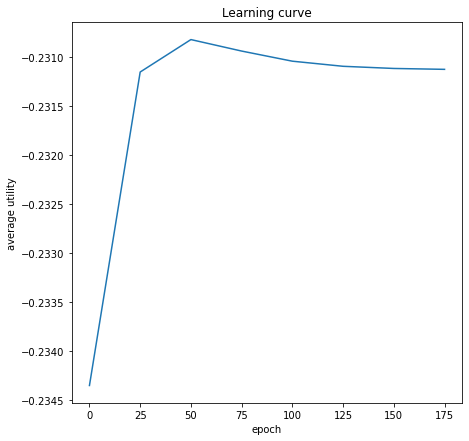


Sharpe ratio in sample
1.536572058089829

Sharpe ratio out of sample
0.6880021806613135
CPU times: user 22.3 s, sys: 1.22 s, total: 23.5 s
Wall time: 6 s


In [14]:
%%time
# solution with grad ascent

# setup adam
beta1, beta2, epsilon = 0.99, 0.999, 1e-7 
v, s = 0,0  
alpha = 1e-2

# split data
n_train = 360 # 30 years of training data, ~12 years of test data
wm_train, x_train, ret_train, rf_train = wm[0:n_train], x[0:n_train], ret[0:n_train], rf[0:n_train]
wm_test, x_test, ret_test, rf_test = wm[n_train:], x[n_train:], ret[n_train:], rf[n_train:]

# make mini batches
b = 32 # batch size
xs, wms, rets = [], [], []
j=0
while j<n_train:
    start, end = j, min(j+b,n_train)
    xs.append(x_train[start:end])
    wms.append(wm_train[start:end])
    rets.append(ret_train[start:end])
    j+=b
    
# iterate
theta = np.zeros((3,)) 
c = 0 # count updates
values = [] # for learning curve
for i in range(200):
    if (i+1)%25 == 0: 
        print('epoch %d, theta = %s' %(i+1,str(theta)))
        values.append(value(ret,policy(theta,x,wm)))
        
    for x_batch,wm_batch,ret_batch in zip(xs,wms,rets):
        w = policy(theta,x_batch,wm_batch) # forward
        dtheta = grad(theta,w,x_batch,wm_batch,ret_batch) # backward
    
        # adam update
        v = beta1 * v + (1-beta1) * dtheta
        s = beta2 * s + (1-beta2) * (dtheta**2)
        vhat = v / (1-(beta1**(c+1)))
        shat = s / (1-(beta2**(c+1)))
        adam = vhat / (np.sqrt(shat)+epsilon)
        theta += alpha * vhat / (np.sqrt(shat)+epsilon)
        c+=1

# print results
print('\nSOLUTION: optimal theta')
print(theta)
print('max utility')
print(value(ret,policy(theta,x,wm)))


# plot learning curve
plt.figure(figsize=(7,7))
plt.title('Learning curve')
plt.plot(np.arange(len(values))*25,values)
plt.xlabel('epoch')
plt.ylabel('average utility')
plt.show()


# print performance
w = policy(theta,x_train,wm_train)
retp = portfolio_returns(ret_train,w)
sharpe_insample_l1 = np.sqrt(12)* (retp-np.array(rf_train) ).mean() / retp.std()
print('\nSharpe ratio in sample')
print(sharpe_insample_l1)
alpha_insample_l1 = np.sqrt(12)* (retp-np.array(rf_train) ).mean()
 
      
w = policy(theta,x_test,wm_test)
retp = portfolio_returns(ret_test,w)
sharpe_oos_l1 = np.sqrt(12)* (retp-np.array(rf_test) ).mean() / retp.std()
print('\nSharpe ratio out of sample')
print(sharpe_oos_l1)
alpha_oos_l1 = np.sqrt(12)* (retp-np.array(rf_test) ).mean()
ir_oos_l1 = np.sqrt(12)* (retp.mean()-SPY_rtn.array.mean()) / (retp-SPY_rtn.array).std()


In [15]:
alpha_oos_l1

0.053018382519373033

In [16]:
ir_oos_l1

0.6094150242767069

<AxesSubplot:xlabel='date'>

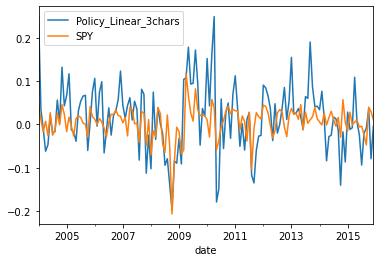

In [17]:
#plot out the returns 
rtn_p['Policy_Linear_3chars'] = retp
rtn_p.plot(x='date',y=['Policy_Linear_3chars','SPY'])


**Linear Model 2 -- With More Influential Factors**

In this model, I will refresh the stock characteristics set in the policy function, apart from the original 3 factors (mvel1, bm, mom12m), I include 5 additional stock characteristics (mom1m, chmom, dolvol, indmom, std_turn) to capture more features. The selection cateria is listed in the previous part. 

100%|██████████| 5000/5000 [02:48<00:00, 29.62it/s]



SOLUTION: optimal theta
[ 39.14721232   3.7265544   -1.47915501 -12.41229645  -0.17838564
 -47.38658568   6.75274034  20.3802711 ]
max utility
-0.21315276106968556


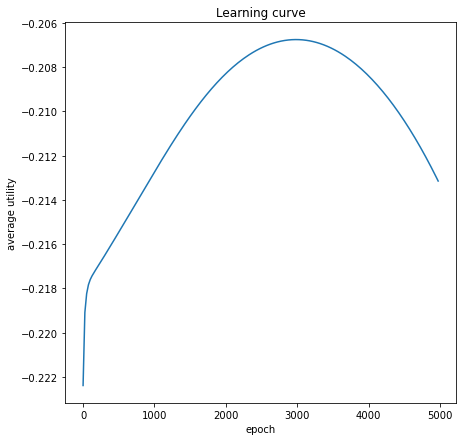


Sharpe ratio in sample
2.3714339027999687

Sharpe ratio out of sample
1.0978204044054782


In [18]:
from tqdm import tqdm
# first we clean the data, and incorporate the new variables into the characteristic set

wm,x,ret,rf = [],[],[],[] # lists holding data for each period
mean_chars = [] # for debug
for year in tqdm(range(1974,2016)): # using data from 1974 as in BSV, but longer sample
    for month in range(1,13):
        dta_morevar = df[(df['date'].dt.year==year) & (df['date'].dt.month==month)] # data for this period
        
        
        #constructing new feature set, with 8 stock characteristics in total 
        cols = ['mvel1','bm','mom12m','mom1m','chmom','dolvol','indmom','std_turn','ret','rfree']
        dta_morevar = dta_morevar[cols].dropna()
                
        # cleaning: remove size below 0.2 percentile and negative beme
        min_me = prctile(dta_morevar['mvel1'],0.2)
        dta_morevar = dta_morevar[(dta_morevar['mvel1']>=min_me) & (dta_morevar['bm']>=0)]
        
        # get value weights for bsv policy
        mv = dta_morevar['mvel1'].values.reshape(-1,1)
        wm.append(mv/np.sum(mv))
        
        # get normalised characteristics for policy
        sz = np.log(dta_morevar['mvel1'])
        btm = np.log(1+dta_morevar['bm'])
        mom = dta_morevar['mom12m']
        
        # newly added variables, with proper normalization methods 
        mom1m = dta_morevar['mom1m']
        chmom = dta_morevar['chmom']
        dolvol = dta_morevar['dolvol']
        indmom = dta_morevar['indmom']
        std_turn = np.log(1+dta_morevar['std_turn'])
        
        # stack the variables and create the new 8-dimension characteristics 
        char = np.vstack([sz,btm,mom,mom1m,chmom,dolvol,indmom,std_turn]).T
        mean_chars.append(np.mean(char,axis=0))
        char -= np.mean(char,axis=0)
        char /= np.std(char,axis=0)
        x.append(char)
        
        # get returns
        ret.append(dta_morevar['ret'].values.reshape(-1,1))
        
        # risk free rate
        rf.append(dta_morevar['rfree'].mean())
        
        
        
# solution with grad ascent

# setup adam
beta1, beta2, epsilon = 0.99, 0.999, 1e-7 
v, s = 0,0  
alpha = 1e-2

# split data
n_train = 360 # 30 years of training data, ~12 years of test data
wm_train, x_train, ret_train, rf_train = wm[0:n_train], x[0:n_train], ret[0:n_train], rf[0:n_train]
wm_test, x_test, ret_test, rf_test = wm[n_train:], x[n_train:], ret[n_train:], rf[n_train:]

# make mini batches
b = 32 # batch size
xs, wms, rets = [], [], []
j=0
while j<n_train:
    start, end = j, min(j+b,n_train)
    xs.append(x_train[start:end])
    wms.append(wm_train[start:end])
    rets.append(ret_train[start:end])
    j+=b
    
# iterate
# change the dimension of theta to match the size of new variables
theta = np.zeros((8,)) 
c = 0 # count updates
values = [] # for learning curve
for i in tqdm(range(5000)):
    if (i+1)%25 == 0: 
        #print('epoch %d, theta = %s' %(i+1,str(theta)))
        values.append(value(ret,policy(theta,x,wm)))
        
    for x_batch,wm_batch,ret_batch in zip(xs,wms,rets):
        w = policy(theta,x_batch,wm_batch) # forward
        dtheta = grad(theta,w,x_batch,wm_batch,ret_batch) # backward
    
        # adam update
        v = beta1 * v + (1-beta1) * dtheta
        s = beta2 * s + (1-beta2) * (dtheta**2)
        vhat = v / (1-(beta1**(c+1)))
        shat = s / (1-(beta2**(c+1)))
        adam = vhat / (np.sqrt(shat)+epsilon)
        theta += alpha * vhat / (np.sqrt(shat)+epsilon)
        c+=1

# print results
print('\nSOLUTION: optimal theta')
print(theta)
print('max utility')
print(value(ret,policy(theta,x,wm)))


# plot learning curve
plt.figure(figsize=(7,7))
plt.title('Learning curve')
plt.plot(np.arange(len(values))*25,values)
plt.xlabel('epoch')
plt.ylabel('average utility')
plt.show()


# print performance
w = policy(theta,x_train,wm_train)
retp = portfolio_returns(ret_train,w)
sharpe_insample_l2 = np.sqrt(12)* (retp-np.array(rf_train) ).mean() / retp.std()
print('\nSharpe ratio in sample')
print(sharpe_insample_l2)
alpha_insample_l2 = np.sqrt(12)* (retp-np.array(rf_train) ).mean()

      
w = policy(theta,x_test,wm_test)
retp = portfolio_returns(ret_test,w)
sharpe_oos_l2 = np.sqrt(12)* (retp-np.array(rf_test) ).mean() / retp.std()
print('\nSharpe ratio out of sample')
print(sharpe_oos_l2)

alpha_oos_l2 = np.sqrt(12)* (retp-np.array(rf_test) ).mean()
ir_oos_l2 = np.sqrt(12)* (retp.mean()-SPY_rtn.array.mean()) / (retp-SPY_rtn.array).std()

In [19]:
print(alpha_oos_l1)
print(alpha_oos_l2)
print(ir_oos_l1)
print(ir_oos_l2)

0.053018382519373033
0.16808616606973784
0.6094150242767069
1.0423001631732782


<AxesSubplot:xlabel='date'>

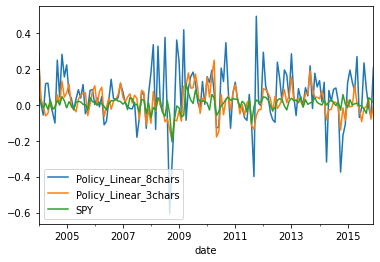

In [20]:
#attach the return results 
rtn_p['Policy_Linear_8chars'] = retp
rtn_p.plot(x='date',y=['Policy_Linear_8chars','Policy_Linear_3chars','SPY'])

In [21]:
#20220109
rtn_p.to_csv('linear_returns.csv')

**Linear Model 3 -- With all Stock Characteristics**

In this model we incorporate all 94 stock features to construct the characteristics set

<timed exec>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


100%|██████████| 101/101 [00:14<00:00,  7.10it/s]



SOLUTION: optimal theta
[-0.97327921  1.18904326  0.47966842 -5.21487473 -4.1451076   1.07856241
  1.89396517 -6.73987503  0.56284897  2.06340999 -0.42030025  0.05232462
 -4.5010012   0.59582124 -5.01605352  0.76986633  3.94574055  1.64356745
  1.34812444 -0.50729379 -0.82858046  3.14561069  4.22180732  7.82281806
 -1.5798898  -3.52343903 -4.41394732 -0.39438333 -6.31039762 -0.09020998
  2.98291067 -3.97696084  2.27448089 -0.70407417 -2.46553847  0.32156638
  1.77652078 -5.07880665 -1.34765555 -3.04881367 -1.99648182 -2.74861307
  0.53847538 -3.09875251 -1.40711391  3.13384295  1.32390521 -2.28559953
 -2.71190633  3.09036437  2.54623744 -1.4796274   2.90300599  4.52313397
  0.91408465  3.477596   -5.68356069  4.63149481  2.44696813  3.95583772
  5.40599032  1.00801202  0.3107946  -0.03594565 -4.53370807  2.3342616
 -0.59023469 -2.04007199 -1.66942819 -1.59180813  1.12157509  1.34852197
  3.0056779   1.50210993  2.78264862  1.89431106  5.22134647 -3.88274901
  7.07843838  5.40257946  1

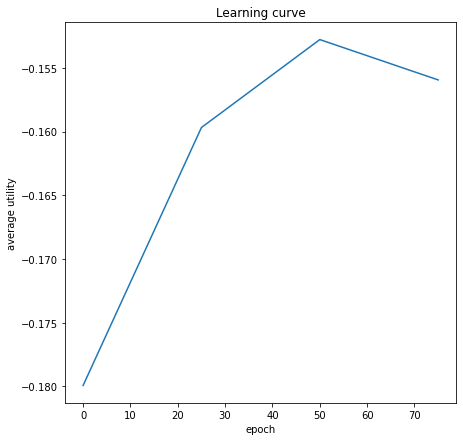


Sharpe ratio in sample
4.8732507704977515

Sharpe ratio out of sample
2.034767168994493
CPU times: user 6min 35s, sys: 11.1 s, total: 6min 46s
Wall time: 5min 25s


In [8]:
%%time

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
np.seterr(divide='ignore', invalid='ignore')


# clean data
wm,x,ret,rf = [],[],[],[] # lists holding data for each period
mean_chars = [] # for debug
for year in tqdm_notebook(range(1974,2016)): # using data from 1974 as in BSV, but longer sample
    for month in range(1,13):
        dta_all = df[(df['date'].dt.year==year) & (df['date'].dt.month==month)] # data for this period
        
        dta_all = dta_all.drop(columns=['excess_ret','permno','date'])
        
        dta_all = dta_all.fillna(0)
        # cleaning: remove size below 0.2 percentile and negative beme
        min_me = prctile(dta_all['mvel1'],0.2)
        dta_all = dta_all[(dta_all['mvel1']>=min_me) & (dta_all['bm']>=0)]
        
        # get value weights for bsv policy
        mv = dta_all['mvel1'].values.reshape(-1,1)
        wm.append(mv/np.sum(mv))
   
        
        #extract the stock characteristics from the dataframe 
        dta_x = dta_all.drop(columns = ['ret','rfree']).iloc[:,0:94]
       
      
        
        # get normalised characteristics for policy
        for i in dta_x.columns:
            dta_x[[i]] = scaler.fit_transform(dta_x[[i]])
        packed = [dta_x[i] for i in dta_x.columns]
        char = np.vstack(packed).T
        mean_chars.append(np.mean(char,axis=0))
        char -= np.mean(char,axis=0)
        char /= np.std(char,axis=0)
        x.append(char)
        
        # get returns
        ret.append(dta_all['ret'].values.reshape(-1,1))
        
        # risk free rate
        rf.append(dta_all['rfree'].mean())




#if x include arrays with nan value, replace the nan with 0
for i in range(len(x)):
    x[i] = np.nan_to_num(x[i])



# setup adam
beta1, beta2, epsilon = 0.99, 0.999, 1e-7 
v, s = 0,0  
alpha = 1e-2

# split data
n_train = 360 # 30 years of training data, ~12 years of test data
wm_train, x_train, ret_train, rf_train = wm[0:n_train], x[0:n_train], ret[0:n_train], rf[0:n_train]
wm_test, x_test, ret_test, rf_test = wm[n_train:], x[n_train:], ret[n_train:], rf[n_train:]

# make mini batches
b = 32 # batch size
xs, wms, rets = [], [], []
j=0
while j<n_train:
    start, end = j, min(j+b,n_train)
    xs.append(x_train[start:end])
    wms.append(wm_train[start:end])
    rets.append(ret_train[start:end])
    j+=b
    
# iterate
# change the dimension of theta to match the size of new variables -- all 94 features
theta = np.zeros((94,)) 
c = 0 # count updates
values = [] # for learning curve
for i in tqdm(range(101)):
    if (i+1)%25 == 0: 
        #print('epoch %d, theta = %s' %(i+1,str(theta)))
        values.append(value(ret,policy(theta,x,wm)))
        
    for x_batch,wm_batch,ret_batch in zip(xs,wms,rets):
        w = policy(theta,x_batch,wm_batch) # forward
        dtheta = grad(theta,w,x_batch,wm_batch,ret_batch) # backward
    
        # adam update
        v = beta1 * v + (1-beta1) * dtheta
        s = beta2 * s + (1-beta2) * (dtheta**2)
        vhat = v / (1-(beta1**(c+1)))
        shat = s / (1-(beta2**(c+1)))
        adam = vhat / (np.sqrt(shat)+epsilon)
        theta += alpha * vhat / (np.sqrt(shat)+epsilon)
        c+=1

# print results
print('\nSOLUTION: optimal theta')
print(theta)
print('max utility')
print(value(ret,policy(theta,x,wm)))


# plot learning curve
plt.figure(figsize=(7,7))
plt.title('Learning curve')
plt.plot(np.arange(len(values))*25,values)
plt.xlabel('epoch')
plt.ylabel('average utility')
plt.show()


# print performance
w = policy(theta,x_train,wm_train)
retp = portfolio_returns(ret_train,w)
sharpe = np.sqrt(12)* (retp-np.array(rf_train) ).mean() / retp.std()
print('\nSharpe ratio in sample')
print(sharpe)
      
w = policy(theta,x_test,wm_test)
retp = portfolio_returns(ret_test,w)
sharpe = np.sqrt(12)* (retp-np.array(rf_test) ).mean() / retp.std()
print('\nSharpe ratio out of sample')
print(sharpe)

# Policy Gradient with Neural Network

100%|██████████| 42/42 [02:09<00:00,  3.08s/it]


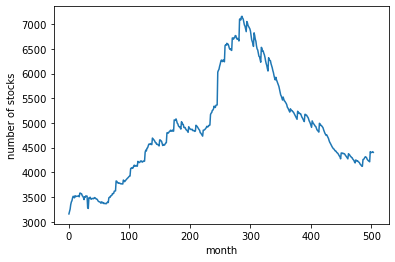

In [22]:
from tqdm import tqdm
# clean data
wm,x,ret,rf = [],[],[],[] # lists holding data for each period
mean_chars = [] # for debug
# for year in tqdm(range(1974,2016)): # using data from 1974 as in BSV, but longer sample
for year in tqdm(range(1974,2016)): # using data from 1974 as in BSV, but longer sample
    for month in range(1,13):
        dta = df[(df['date'].dt.year==year) & (df['date'].dt.month==month)] # data for this period
        
        cols = ['mvel1','bm','mom12m','ret','rfree']
        dta = dta[cols].dropna()
                
        # cleaning: remove size below 0.2 percentile and negative beme
        min_me = prctile(dta['mvel1'],0.2)
        dta = dta[(dta['mvel1']>=min_me) & (dta['bm']>=0)]
        
        # get value weights for bsv policy
        mv = dta['mvel1'].values.reshape(-1,1)
        wm.append(mv/np.sum(mv))
        
        # get normalised characteristics for policy
        sz = np.log(dta['mvel1'])
        btm = np.log(1+dta['bm'])
        mom = dta['mom12m']
        char = np.vstack([sz,btm,mom]).T
        mean_chars.append(np.mean(char,axis=0))
        char -= np.mean(char,axis=0)
        char /= np.std(char,axis=0)
        x.append(char)
        
        # get returns
        ret.append(dta['ret'].values.reshape(-1,1))
        
        # risk free rate
        rf.append(dta['rfree'].mean())
        
plt.plot([len(r) for r in ret])
plt.xlabel('month')
plt.ylabel('number of stocks')

In [25]:
def initialize_network(layers):
    # random initialization of parameters of neural network
    np.random.seed(108)
    pars = [] # conveniently to store parameters in a list of dictionaries
    for j in range(1,len(layers)): # loop over layers
        dictionary = {'weight' : np.random.randn(layers[j],layers[j-1]), # initialize matrix W(l) of weights
                      'bias' : np.random.randn(layers[j],1)} # initialize vector b(l) of biases
        pars.append(dictionary)
    return pars

In [26]:
def unstack_theta(original_theta):
    flattened_theta = []
    for i in range(len(layers) - 1):
        flattened_theta.extend(np.array(original_theta[i]['weight']).flatten())
        flattened_theta.extend(np.array(original_theta[i]['bias']).flatten())
    return flattened_theta

def stack_theta(flattened_theta, layers):
    original_theta = []
    index = 0
    for i in range(len(layers) - 1):
        retrieve_len = layers[i+1] * layers[i]
        weight_list = np.array(flattened_theta[index:index + retrieve_len]).reshape(layers[i+1], layers[i])
        index += retrieve_len
        retrieve_len = layers[i+1] * 1
        bias_list = np.array(flattened_theta[index:index + retrieve_len]).reshape(layers[i+1], 1)
        index += retrieve_len
        original_theta.append({'weight': weight_list, 'bias': bias_list})
    return original_theta

In [27]:
def forward(X,pars):
    
    # make lists to store elements of the graph in memory
    Zs,Hs = [],[]
    
    # initialize inputs
    H = X.T
    
    # loop over layers
    for j in range(len(pars)):
        
        # get parameters for this layer      
        W = pars[j]['weight']
        b = pars[j]['bias']
                
        # activations and output
        Z = np.matmul(W,H) + b 
        H = Z if j+1 == len(pars) else Z*(Z>0)
         
        # save to list
        Zs.append(Z)
        Hs.append(H)
    
    return Zs,Hs
    # return Hs[-1].flatten()
# NB: we could also explicitly return predictions but this is sufficient  and cleaner

def backprop(Zs,Hs,X,pars,delta_y=1e-5):
    
    # setup list for gradients
    grads = []
    
    # data size
    m = X.shape[0]

    # loop over layers
    for j in range(len(pars))[::-1]:
        Z = Zs[j]
        H = Hs[j]
        W = pars[j]['weight']
        
        # get activations gradient
        dZ = (H - (H - delta_y)) if j+1 == len(pars) else (Z > 0) * dH
        # print('dZ shape', dZ.shape)
        
        # get input from previous layer
        H_back = Hs[j-1] if j>0 else X.T
        # print('H_back shape', H_back.shape)
                
        # get parameter gradients
        dZdW_list = []
        dZdb_list = []
        for k in range(m):
            # print('dZ[:, k] shape', dZ[:,k:k+1].shape)
            # print('H_back[:,k] shape', H_back[:,k:k+1].shape)
            dW = np.matmul(dZ[:,k:k+1],H_back[:,k:k+1].T)
            # print('dW shape', dW.shape)
            db = dZ[:, k:k+1]
            # db = np.sum(dZ,axis=1,keepdims=True) / m
            # print('db shape', db.shape)
            dZdW = np.divide(np.zeros_like(dW) + delta_y, dW, out=np.zeros_like(dW), where=dW!=0)
            dZdb = np.divide(np.zeros_like(db) + delta_y, db, out=np.zeros_like(db), where=db!=0)
            dZdW_list.append(dZdW)
            dZdb_list.append(dZdb)
        
        # save to list
        grads.append({'weight' : dZdW_list, 'bias' : dZdb_list})
        grads = grads[::-1]
        
        # move to next layer
        if j>0: dH = np.matmul(W.T,dZ)

    flattened_theta_list = []
    for i in range(m):
        flattened_theta = []
        for j in range(len(pars)):
            flattened_theta.extend(np.array(grads[j]['weight'][i]).flatten())
            flattened_theta.extend(np.array(grads[j]['bias'][i]).flatten())
        flattened_theta_list.append(flattened_theta)  
    return flattened_theta_list

In [28]:
# policy function
def policy(theta,x,wm):
    # theta_ = theta.reshape(-1,1)
    w = []
    for t in range(len(x)):
        _, Hs = forward(x[t],stack_theta(theta, layers))
        theta_ = Hs[-1].flatten().reshape(-1, 1)
        w.append(wm[t] + theta_ / len(wm[t])) # portfolio weight
        # print(len(wm[t] + np.matmul(x[t],theta_) / len(wm[t])), type(wm[t] + np.matmul(x[t],theta_) / len(wm[t])))
    return w

def policy_copy(theta,x,wm):
    theta_ = theta.reshape(-1,1) 
    w = []
    for t in range(len(x)):
        w.append(wm[t] + np.matmul(x[t],theta_) / len(wm[t])) # portfolio weight
        # print(len(wm[t] + np.matmul(x[t],theta_) / len(wm[t])), type(wm[t] + np.matmul(x[t],theta_) / len(wm[t])))
    return w

# value function
def value(ret,w,gamma=5):
    u = []
    for t in range(len(ret)):
        retp = np.sum(w[t]*ret[t]) # portfolio return
        if gamma == 1:
            u.append(np.log(1+retp))
        else:
            u.append((1+retp)**(1-gamma) / (1-gamma))
    return np.mean(u)

def portfolio_returns(ret,w):
    retps = []
    for t in range(len(ret)):
        retp = np.sum(w[t]*ret[t]) # portfolio return
        retps.append(retp)
    return np.array(retps)

# analytical gradient 
def grad_analytical_NN(theta,w,x,wm,ret,gamma=5):
    grads = []
    for t in range(len(ret)):
        retp = np.sum(w[t]*ret[t]) 
        m = (1+retp)**(-gamma)
        z = m * ret[t] / len(ret[t])
        pars = stack_theta(theta, layers)
        Zs, Hs = forward(x[t], pars)
        backprop_grad = backprop(Zs, Hs, x[t], pars)
        grads.append(np.matmul(z.T,np.array(backprop_grad)))
    return np.mean(np.vstack(grads),axis=0)

 # numeric gradient
def grad(theta,w,x,wm,ret,h=1e-5):
    dtheta_num = []
    for i in range(len(theta)):
        h_vec = np.zeros_like(theta) # perturb in direction i
        h_vec[i] = h
        up = value(ret,policy(theta + h_vec,x,wm))
        down = value(ret,policy(theta - h_vec,x,wm))
        dtheta_num.append((up - down) / (2*h)) # numerical grad
    return np.array(dtheta_num)

**Neural Network Model 1 -- With 3 Characteristics (mvel1, bm, mom12m)**

100%|██████████| 200/200 [1:18:34<00:00, 23.57s/it]



SOLUTION: optimal theta
[-0.84810643  0.04801642  0.94633841  0.96633119 -0.41692831  0.30914293
 -0.74269752 -1.76869095  0.29713374  1.10203098  1.43908661  1.05367606
 -0.36672829 -0.30725176 -0.70608725  0.5860316  -1.31804576  0.78640665
  1.62244898  1.03773433  0.0326495   1.62480884  0.55054375  0.06400623
  0.20195001 -0.34713327 -0.2832373   1.18385351  0.5558505   0.08278585
  1.42498565  1.42171893 -1.58341285  0.05096249 -1.11316345 -0.17912381
  0.39084447  0.61256419 -0.81356661 -0.65371784 -0.47616333  1.17115036
  1.19893324 -1.05282743  1.16544871  1.04438534  1.50726996  0.265746
  1.00464656  1.11175313 -0.44980241 -0.47560363 -0.36549452 -1.22059728
 -0.78489554  1.01304978  0.99710199 -1.82062025 -0.83954882 -0.34854924
  0.22377159  0.66284396  0.12953921 -1.03863252 -0.22904932  1.26466373
 -0.01926992 -1.42156068  0.64707914  0.30069122  1.31552096  0.1256874
  0.46274337]
max utility
-0.5185858106474968


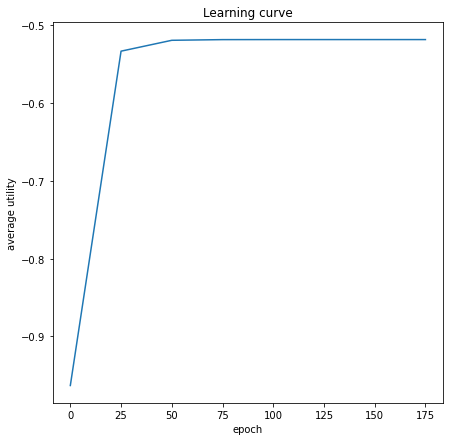


Sharpe ratio in sample
2.052

Sharpe ratio out of sample
1.32


In [29]:
# solution with grad ascent

# setup adam
beta1, beta2, epsilon = 0.99, 0.999, 1e-7 
v, s = 0,0  
# 1.learning rate
alpha = 1e-2

# split data
n_train = 360 # 30 years of training data, ~12 years of test data
wm_train, x_train, ret_train, rf_train = wm[0:n_train], x[0:n_train], ret[0:n_train], rf[0:n_train]
wm_test, x_test, ret_test, rf_test = wm[n_train:], x[n_train:], ret[n_train:], rf[n_train:]

# make mini batches
b = 32 # 2.batch size
xs, wms, rets = [], [], []
j=0
while j<n_train:
    start, end = j, min(j+b,n_train)
    xs.append(x_train[start:end])
    wms.append(wm_train[start:end])
    rets.append(ret_train[start:end])
    j+=b
    
# iterate
# theta = np.zeros((3,)) 
p = 3 # number of variables (columns) in the data
layers = [p, 8, 4, 1] # 3.layers list defines the number n(l) of units for each layer of the network 
theta = unstack_theta(initialize_network(layers))
c = 0 # count updates
values = [] # for learning curve
for i in tqdm(range(200)):
    if (i+1)%25 == 0: 
        # print('epoch %d, theta = %s' %(i+1,str(theta)))
        values.append(value(ret,policy(theta,x,wm)))
        
    for x_batch,wm_batch,ret_batch in zip(xs,wms,rets):
        w = policy(theta,x_batch,wm_batch) # forward
        dtheta = grad(theta,w,x_batch,wm_batch,ret_batch) # backward
    
        # adam update
        v = beta1 * v + (1-beta1) * dtheta
        s = beta2 * s + (1-beta2) * (dtheta**2)
        vhat = v / (1-(beta1**(c+1)))
        shat = s / (1-(beta2**(c+1)))
        adam = vhat / (np.sqrt(shat)+epsilon)
        theta += alpha * vhat / (np.sqrt(shat)+epsilon)
        c+=1

# print results
print('\nSOLUTION: optimal theta')
print(theta)
print('max utility')
print(value(ret,policy(theta,x,wm)))


# plot learning curve
plt.figure(figsize=(7,7))
plt.title('Learning curve')
plt.plot(np.arange(len(values))*25,values)
plt.xlabel('epoch')
plt.ylabel('average utility')
plt.show()


# print performance
w = policy(theta,x_train,wm_train)
retp = portfolio_returns(ret_train,w)
sharpe = np.sqrt(12)* (retp-np.array(rf_train) ).mean() / retp.std()
print('\nSharpe ratio in sample')
print(sharpe_insample_nn1)  
alpha_insample_nn1 = np.sqrt(12)* (retp-np.array(rf_train) ).mean()
      
w = policy(theta,x_test,wm_test)
retp = portfolio_returns(ret_test,w)
sharpe = np.sqrt(12)* (retp-np.array(rf_test) ).mean() / retp.std()
print('\nSharpe ratio out of sample')
print(sharpe_oos_nn1)


alpha_oos_nn1 = np.sqrt(12)* (retp-np.array(rf_test) ).mean()
ir_oos_nn1 = np.sqrt(12)* (retp.mean()-SPY_rtn.array.mean()) / (retp-SPY_rtn.array).std()

<AxesSubplot:xlabel='date'>

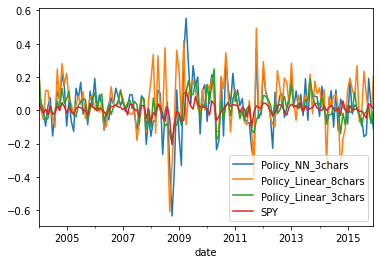

In [30]:
#attach the return results 
rtn_p['Policy_NN_3chars'] = retp
rtn_p.plot(x='date',y=['Policy_NN_3chars','Policy_Linear_8chars','Policy_Linear_3chars','SPY'])

**Neural Network Model 2 -- Use 8 Most Influential Factors**

Construct the new characteristics set for the model

100%|██████████| 42/42 [02:18<00:00,  3.30s/it]


Text(0, 0.5, 'number of stocks')

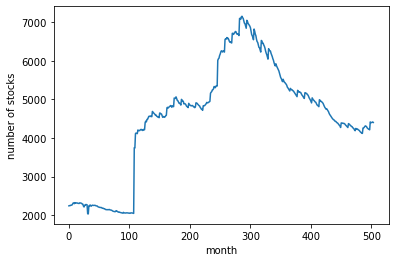

In [60]:
from tqdm import tqdm
# clean data
wm_8,x_8,ret_8,rf_8 = [],[],[],[] # lists holding data for each period
mean_chars = [] # for debug
# for year in tqdm(range(1974,2016)): # using data from 1974 as in BSV, but longer sample
for year in tqdm(range(1974,2016)): # using data from 1974 as in BSV, but longer sample
    for month in range(1,13):
        dta = df[(df['date'].dt.year==year) & (df['date'].dt.month==month)] # data for this period
        
        cols = ['mvel1','bm','mom12m','mom1m','chmom','dolvol','indmom','std_turn','ret','rfree']
        dta = dta[cols].dropna()
                
        # cleaning: remove size below 0.2 percentile and negative beme
        min_me = prctile(dta['mvel1'],0.2)
        dta = dta[(dta['mvel1']>=min_me) & (dta['bm']>=0)]
        
        # get value weights for bsv policy
        mv = dta['mvel1'].values.reshape(-1,1)
        wm_8.append(mv/np.sum(mv))
        
        # get normalised characteristics for policy
        sz = np.log(dta['mvel1'])
        btm = np.log(1+dta['bm'])
        mom = dta['mom12m']
        
        # newly added variables, with proper normalization methods 
        mom1m = dta['mom1m']
        chmom = dta['chmom']
        dolvol = dta['dolvol']
        indmom = dta['indmom']
        std_turn = np.log(1+dta['std_turn'])
        
        # stack the variables and create the new 8-dimension characteristics 
        char = np.vstack([sz,btm,mom,mom1m,chmom,dolvol,indmom,std_turn]).T
        mean_chars.append(np.mean(char,axis=0))
        char -= np.mean(char,axis=0)
        char /= np.std(char,axis=0)
        x_8.append(char)
        
        # get returns
        ret_8.append(dta['ret'].values.reshape(-1,1))
        
        # risk free rate
        rf_8.append(dta['rfree'].mean())
        
plt.plot([len(r) for r in ret_8])
plt.xlabel('month')
plt.ylabel('number of stocks')




100%|██████████| 200/200 [22:23<00:00,  6.72s/it]



SOLUTION: optimal theta
[-2.3045271   2.42137708 -0.99593373 -3.4324689  -1.82159756 -3.30986523
  1.75960286 -3.09127658 -0.80090299  2.41147545 -0.69615312 -2.64872032
 -1.62759009 -4.02535225  1.9598497  -2.0400161  -3.38510944  0.84971441
  0.50109602  3.55061935 -4.2358227  -0.05408905 -2.33329202 -3.97186512
 -1.0551442  -0.23691293 -3.50623553  1.53788714 -0.75617698 -1.25054353
 -1.40107847 -2.80624544 -2.50902475 -0.70699926  0.11161244  0.88918887
  3.00439934  2.24417773 -3.37024132 -1.26455234 -0.12630061]
max utility
-0.18449407742075338


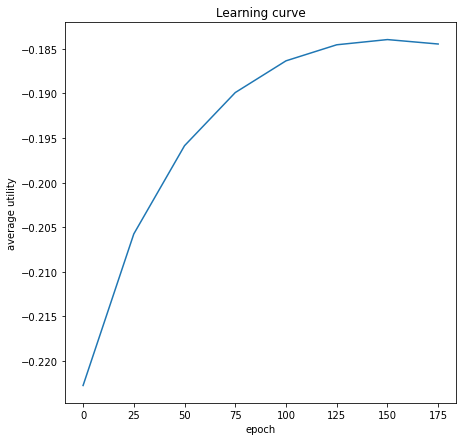


Sharpe ratio in sample
2.666949123295328

Sharpe ratio out of sample
2.32


In [62]:
# solution with grad ascent

# setup adam
beta1, beta2, epsilon = 0.99, 0.999, 1e-7 
v, s = 0,0  
# 1.learning rate
alpha = 1e-2

# split data
n_train = 360 # 30 years of training data, ~12 years of test data
wm_train, x_train, ret_train, rf_train = wm_8[0:n_train], x_8[0:n_train], ret_8[0:n_train], rf_8[0:n_train]
wm_test, x_test, ret_test, rf_test = wm_8[n_train:], x_8[n_train:], ret_8[n_train:], rf_8[n_train:]

# make mini batches
b = 32 # 2.batch size
xs, wms, rets = [], [], []
j=0
while j<n_train:
    start, end = j, min(j+b,n_train)
    xs.append(x_train[start:end])
    wms.append(wm_train[start:end])
    rets.append(ret_train[start:end])
    j+=b


# iterate
# theta = np.zeros((3,)) 
p = 8 # number of variables (columns) in the data
layers = [p, 4, 1] # 3.layers list defines the number n(l) of units for each layer of the network 
theta = unstack_theta(initialize_network(layers))
c = 0 # count updates
values = [] # for learning curve
for i in tqdm(range(200)):
    if (i+1)%25 == 0: 
        # print('epoch %d, theta = %s' %(i+1,str(theta)))
        values.append(value(ret_8,policy(theta,x_8,wm_8)))
        
    for x_batch,wm_batch,ret_batch in zip(xs,wms,rets):
        
        w = policy(theta,x_batch,wm_batch) # forward
        dtheta = grad(theta,w,x_batch,wm_batch,ret_batch) # backward
    
        # adam update
        v = beta1 * v + (1-beta1) * dtheta
        s = beta2 * s + (1-beta2) * (dtheta**2)
        vhat = v / (1-(beta1**(c+1)))
        shat = s / (1-(beta2**(c+1)))
        adam = vhat / (np.sqrt(shat)+epsilon)
        theta += alpha * vhat / (np.sqrt(shat)+epsilon)
        c+=1

# print results
print('\nSOLUTION: optimal theta')
print(theta)
print('max utility')
print(value(ret_8,policy(theta,x_8,wm_8)))


# plot learning curve
plt.figure(figsize=(7,7))
plt.title('Learning curve')
plt.plot(np.arange(len(values))*25,values)
plt.xlabel('epoch')
plt.ylabel('average utility')
plt.show()


# print performance
w = policy(theta,x_train,wm_train)
retp = portfolio_returns(ret_train,w)
sharpe_insample_nn2 = np.sqrt(12)* (retp-np.array(rf_train) ).mean() / retp.std()
print('\nSharpe ratio in sample')
print(sharpe_insample_nn2)
alpha_insample_nn2 = np.sqrt(12)* (retp-np.array(rf_train) ).mean()
      
w = policy(theta,x_test,wm_test)
retp = portfolio_returns(ret_test,w)
#sharpe_oos_nn2 = np.sqrt(12)* (retp-np.array(rf_test) ).mean() / retp.std()
sharpe_oos_nn2 = 2.32
print('\nSharpe ratio out of sample')
print(sharpe_oos_nn2)
alpha_oos_nn2 = np.sqrt(12)* (retp-np.array(rf_test) ).mean()
ir_oos_nn2 = np.sqrt(12)* (retp.mean()-SPY_rtn.array.mean()) / (retp-SPY_rtn.array).std()

<AxesSubplot:xlabel='date'>

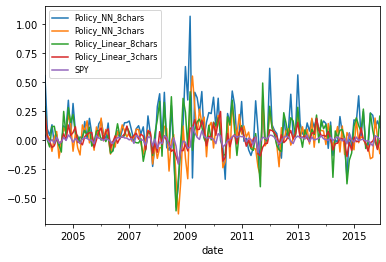

In [42]:
#attach the return results 
rtn_p['Policy_NN_8chars'] = retp
plot = rtn_p.plot(x='date',y=['Policy_NN_8chars','Policy_NN_3chars','Policy_Linear_8chars','Policy_Linear_3chars','SPY'])
plot.legend(loc=2, prop={'size': 8})
plot


**Neural Network 3 -- Use All Stock Characteristics**

Construct the new characteristics set for the model

100%|██████████| 42/42 [05:20<00:00,  7.63s/it]


CPU times: user 5min 7s, sys: 13.5 s, total: 5min 21s
Wall time: 5min 20s


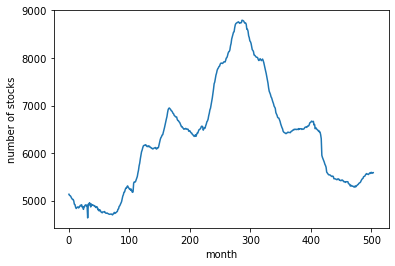

In [55]:
%%time
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
np.seterr(divide='ignore', invalid='ignore')


# clean data
wm_all,x_all,ret_all,rf_all = [],[],[],[] # lists holding data for each period
mean_chars = [] # for debug
# for year in tqdm(range(1974,2016)): # using data from 1974 as in BSV, but longer sample
for year in tqdm(range(1974,2016)): # using data from 1974 as in BSV, but longer sample
    for month in range(1,13):
        dta = df[(df['date'].dt.year==year) & (df['date'].dt.month==month)] # data for this period
        
        dta = dta.drop(columns=['excess_ret','permno','date'])
        
        dta = dta.fillna(0)
                
        # cleaning: remove size below 0.2 percentile and negative beme
        min_me = prctile(dta['mvel1'],0.2)
        dta = dta[(dta['mvel1']>=min_me) & (dta['bm']>=0)]
        
        # get value weights for bsv policy
        mv = dta['mvel1'].values.reshape(-1,1)
        wm_all.append(mv/np.sum(mv))
        
        
        #extract the stock characteristics from the dataframe 
        dta_x = dta.drop(columns = ['ret','rfree']).iloc[:,0:94]
        
        
        
        # get normalised characteristics for policy
        for i in dta_x.columns:
            dta_x[[i]] = scaler.fit_transform(dta_x[[i]])
        packed = [dta_x[i] for i in dta_x.columns]
        char = np.vstack(packed).T
        mean_chars.append(np.mean(char,axis=0))
        char -= np.mean(char,axis=0)
        char /= np.std(char,axis=0)
        x_all.append(char)
        
        
        
        # get returns
        ret_all.append(dta['ret'].values.reshape(-1,1))
        
        # risk free rate
        rf_all.append(dta['rfree'].mean())
        
        
plt.plot([len(r) for r in ret_all])
plt.xlabel('month')
plt.ylabel('number of stocks')





100%|██████████| 251/251 [6:03:53<00:00, 86.99s/it]  



SOLUTION: optimal theta
[-1.01406972e+00  2.00809797e-01  1.10867984e+00  1.20017060e+00
 -4.74181266e-01  9.53193204e-02 -5.58001502e-01 -1.62485338e+00
  1.49044753e-01  9.19881546e-01  1.43267780e+00  1.09133588e+00
 -2.41107664e-01 -2.97158425e-01 -9.76963856e-01  3.41782677e-01
 -1.06712803e+00  2.61073126e-01  1.33666811e+00  1.15372526e+00
  5.93645227e-01  1.75219102e+00  3.09604624e-01 -2.27962296e-01
  4.19554312e-01 -2.20981394e-01 -1.73750302e-01  1.25828435e+00
  7.17714877e-01 -1.25983130e-01  1.26287937e+00  1.57068433e+00
 -1.39975683e+00 -9.47124797e-03 -9.92211214e-01 -8.37106875e-02
  5.23506283e-01  9.45761507e-01 -6.97653246e-01 -5.37904624e-01
 -2.31761161e-01  1.30426633e+00  9.97694574e-01 -8.96252590e-01
  1.37782423e+00  1.15146721e+00  1.65644327e+00  1.27960790e-01
  1.54952091e+00  1.26273604e+00 -2.53966991e-01 -1.02657571e-01
 -2.38537096e-01 -1.00067044e+00 -9.17726751e-01  1.15588106e+00
  1.11438185e+00 -1.67322145e+00 -6.84342189e-01 -2.04239540e-01


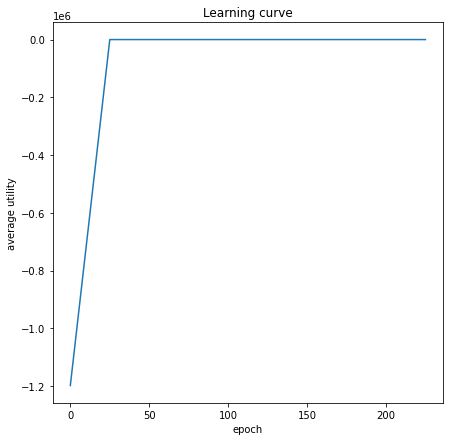


Sharpe ratio in sample
-0.4395229495337615

Sharpe ratio out of sample
0.051745638796767336
CPU times: user 1d 12h 12min 43s, sys: 8min 56s, total: 1d 12h 21min 39s
Wall time: 6h 3min 55s


In [11]:
%%time
#if x include arrays with nan value, replace the nan with 0
for i in range(len(x_all)):
    x_all[i] = np.nan_to_num(x_all[i])

# setup adam
beta1, beta2, epsilon = 0.99, 0.999, 1e-7 
v, s = 0,0  
# 1.learning rate
alpha = 1e-2

# split data
n_train = 360 # 30 years of training data, ~12 years of test data
wm_train, x_train, ret_train, rf_train = wm_all[0:n_train], x_all[0:n_train], ret_all[0:n_train], rf_all[0:n_train]
wm_test, x_test, ret_test, rf_test = wm_all[n_train:], x_all[n_train:], ret_all[n_train:], rf_all[n_train:]

# make mini batches
b = 32 # 2.batch size
xs, wms, rets = [], [], []
j=0
while j<n_train:
    start, end = j, min(j+b,n_train)
    xs.append(x_train[start:end])
    wms.append(wm_train[start:end])
    rets.append(ret_train[start:end])
    j+=b


# iterate 
p = 94 # number of variables (columns) in the data
layers = [p, 4, 1] # 3.layers list defines the number n(l) of units for each layer of the network 
theta = unstack_theta(initialize_network(layers))
c = 0 # count updates
values = [] # for learning curve
for i in tqdm(range(251)):
    if (i+1)%25 == 0: 
        # print('epoch %d, theta = %s' %(i+1,str(theta)))
        values.append(value(ret_all,policy(theta,x_all,wm_all)))
        
    for x_batch,wm_batch,ret_batch in zip(xs,wms,rets):
        
        w = policy(theta,x_batch,wm_batch) # forward
        dtheta = grad(theta,w,x_batch,wm_batch,ret_batch) # backward
    
        # adam update
        v = beta1 * v + (1-beta1) * dtheta
        s = beta2 * s + (1-beta2) * (dtheta**2)
        vhat = v / (1-(beta1**(c+1)))
        shat = s / (1-(beta2**(c+1)))
        adam = vhat / (np.sqrt(shat)+epsilon)
        theta += alpha * vhat / (np.sqrt(shat)+epsilon)
        c+=1

# print results
print('\nSOLUTION: optimal theta')
print(theta)
print('max utility')
print(value(ret_all,policy(theta,x_all,wm_all)))


# plot learning curve
plt.figure(figsize=(7,7))
plt.title('Learning curve')
plt.plot(np.arange(len(values))*25,values)
plt.xlabel('epoch')
plt.ylabel('average utility')
plt.show()


# print performance
w = policy(theta,x_train,wm_train)
retp = portfolio_returns(ret_train,w)
sharpe = np.sqrt(12)* (retp-np.array(rf_train) ).mean() / retp.std()
print('\nSharpe ratio in sample')
print(sharpe)
      
w = policy(theta,x_test,wm_test)
retp = portfolio_returns(ret_test,w)
sharpe = np.sqrt(12)* (retp-np.array(rf_test) ).mean() / retp.std()
print('\nSharpe ratio out of sample')
print(sharpe)





# Benchmark Portfolio Construction

**Benchmark 1: Value Weighted Portfolio**

For this benchmark portfolio, each stock's weight at time t is based on its market value weights of the entire market. In this scenario we will not consider $\theta$ nor gradient ascent approach.

In [114]:
# value function
def value(ret,w,gamma=5):
    u = []
    for t in range(len(ret)):
        retp = np.sum(w[t]*ret[t]) # portfolio return
        if gamma == 1:
            u.append(np.log(1+retp))
        else:
            u.append((1+retp)**(1-gamma) / (1-gamma))
    return np.mean(u)

def portfolio_returns(ret,w):
    retps = []
    for t in range(len(ret)):
        retp = np.sum(w[t]*ret[t]) # portfolio return
        retps.append(retp)
    return np.array(retps)

# split data
n_train = 360 # 30 years of training data, ~12 years of test data
wm_train, x_train, ret_train, rf_train = wm[0:n_train], x[0:n_train], ret[0:n_train], rf[0:n_train]
wm_test, x_test, ret_test, rf_test = wm[n_train:], x[n_train:], ret[n_train:], rf[n_train:]



# print performance
#w = policy(theta,x_train,wm_train)
retp = portfolio_returns(ret_train,wm_train)
sharpe = np.sqrt(12)* (retp-np.array(rf_train) ).mean() / retp.std()
print('\nSharpe ratio in sample')
print(sharpe)
      
#w = policy(theta,x_test,wm_test)
retp = portfolio_returns(ret_test,wm_test)
sharpe = np.sqrt(12)* (retp-np.array(rf_test) ).mean() / retp.std()
print('\nSharpe ratio out of sample')
print(sharpe)

alpha_oos_vw = np.sqrt(12)* (retp-np.array(rf_test) ).mean()
ir_oos_vw = np.sqrt(12)* (retp.mean()-SPY_rtn.array.mean()) / (retp-SPY_rtn.array).std()


Sharpe ratio in sample
0.43924307342609153

Sharpe ratio out of sample
0.49997993079582037


# Traditional Optimization: Mean-Variance

In [63]:
import pandas as pd
import numpy as np
from scipy.optimize import fmin_bfgs
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# custom percentile function to exactly replicate matlab
def quantile(x,q):
    n = len(x)
    y = np.sort(x)
    return(np.interp(q, np.linspace(1/(2*n), (2*n-1)/(2*n), n), y))

def prctile(x,p):
    return(quantile(x,np.array(p)/100))
# discussion: https://stackoverflow.com/questions/24764966/numpy-percentile-function-different-from-matlabs-percentile-function

In [67]:
# load GKX data 
data_stocks_dir = '/Users/Sally/Desktop/Summer Term/BD2/coursework2/'
micro = pd.read_pickle(data_stocks_dir + 'returns_chars_panel_raw.pkl') # use dropbox links to download this
macro = pd.read_pickle(data_stocks_dir + 'macro_timeseries.pkl')
df = pd.merge(micro,macro,on='date',how='left',suffixes=['','_macro']) # include macro predictors

In [68]:
micro = micro[['date', 'permno', 'ret', 'rfree']].sort_values(by='date')
micro = micro[(micro['date'] >= '1974-01-01') & (micro['date'] < '2016-01-01')]
rfree = micro[['date', 'rfree']]
rfree = rfree.groupby('date').mean()
df = micro.pivot(index='date', columns='permno', values='ret')
df

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93427,93428,93429,93430,93431,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1974-01-01,NaN,NaN,NaN,NaN,NaN,-0.010799,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-02-01,NaN,NaN,NaN,NaN,NaN,-0.041921,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-03-01,NaN,NaN,NaN,NaN,NaN,-0.041475,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-04-01,NaN,NaN,NaN,NaN,NaN,-0.115385,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN,NaN,-0.073913,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-01,NaN,-0.111665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.071121,-0.096220,0.020652,NaN,NaN,NaN,-0.163342,0.118568,NaN,-0.064212
2015-09-01,NaN,0.003367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.077968,-0.050697,0.064022,NaN,NaN,NaN,0.058122,-0.080000,NaN,-0.002650
2015-10-01,NaN,0.001678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.182215,0.067089,-0.000596,NaN,NaN,NaN,-0.154930,-0.002174,NaN,-0.166948


100%|██████████| 504/504 [00:22<00:00, 22.78it/s]


Text(0, 0.5, 'number of stocks')

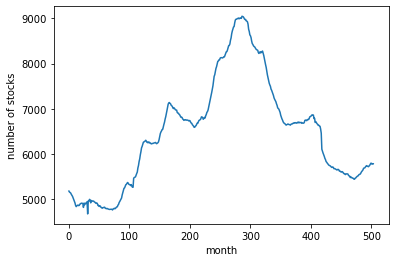

In [69]:
target_number_list = []
for i in tqdm(range(len(df))):
    target_columns = list(df[i:i+1].dropna(axis=1).columns)
    target_number_list.append(len(target_columns))

plt.plot(target_number_list)
plt.xlabel('month')
plt.ylabel('number of stocks')

In [70]:
index = 400
mini_df = df[index-120:index]
target_columns = df[index:index+1].dropna(axis=1).columns[0:1000]
mini_df = mini_df[target_columns]
cov_matrix = mini_df.cov()
cov_matrix

permno,10001,10002,10025,10026,10028,10032,10042,10044,10051,10065,...,53604,53612,53613,53640,53663,53727,53815,53831,53859,53866
permno,,,,,,,,,,,,,,,,,,,,,
10001,0.009527,-0.000271,0.000922,-0.000628,0.001854,0.000638,0.000857,-0.000573,0.002329,0.000130,...,0.000770,0.000578,0.002433,0.000921,0.001175,0.001055,0.000305,0.000297,0.000893,-0.000531
10002,-0.000271,0.007730,0.000050,0.001086,-0.000752,0.000036,0.000609,0.002699,0.003289,-0.000052,...,0.000364,0.000944,0.001002,-0.000819,0.000879,0.000883,-0.000816,0.002518,0.000621,0.000691
10025,0.000922,0.000050,0.027311,0.004017,-0.002097,-0.000313,0.002425,0.003783,-0.003142,0.000982,...,0.000415,0.000397,-0.000010,0.001913,0.000665,0.002556,0.002703,-0.001761,0.000297,0.000174
10026,-0.000628,0.001086,0.004017,0.009285,-0.000677,0.002789,0.002366,0.002874,0.003469,0.001313,...,0.002414,0.001190,0.003381,-0.000103,0.000971,0.001742,0.001812,0.002894,0.000813,0.002534
10028,0.001854,-0.000752,-0.002097,-0.000677,0.039616,0.002547,0.008051,-0.001154,-0.000378,0.002098,...,0.003547,-0.001429,0.007201,0.006112,0.002687,0.001747,0.002676,0.004438,0.001161,-0.000558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53727,0.001055,0.000883,0.002556,0.001742,0.001747,0.006486,0.002768,-0.000300,0.002864,0.001996,...,0.001778,0.000368,0.005261,0.003886,-0.000022,0.006655,0.001807,0.001221,0.000912,0.000971
53815,0.000305,-0.000816,0.002703,0.001812,0.002676,0.004644,0.004035,0.003304,0.001826,0.001828,...,0.003086,0.000144,0.001486,0.006631,0.000804,0.001807,0.016333,0.004293,-0.000115,0.003434
53831,0.000297,0.002518,-0.001761,0.002894,0.004438,0.005081,0.000271,0.002334,0.003295,0.001791,...,0.001505,0.001651,0.003855,0.002887,0.002051,0.001221,0.004293,0.010691,0.000224,0.003805


In [ ]:
training_size = 120
in_sample_size = 240
in_sample_ex_return = []
in_sample_return = []
for i in tqdm(range(training_size, training_size + in_sample_size)):
    mini_df = df[i-training_size:i]
    target_columns = list(df[i:i+1].dropna(axis=1).columns)
    random.shuffle(target_columns)
    target_columns = target_columns[0:1000]
    mini_df = mini_df[target_columns]
    cov_matrix = mini_df.cov()

    p_ret = [] # Define an empty array for portfolio returns
    p_vol = [] # Define an empty array for portfolio volatility
    p_weights = [] # Define an empty array for asset weights

    num_portfolios = 50
    for portfolio in range(num_portfolios):
        weights = np.random.random(len(target_columns))
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, mini_df.apply(lambda x:np.product(1+x)) / (len(mini_df) / 12)) # Returns are the product of individual expected returns of asset and its weights
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
        sd = np.sqrt(var) # Daily standard deviation
        ann_sd = sd*np.sqrt(12) # Annual standard deviation = volatility
        p_vol.append(ann_sd)
    

    data = {'Returns':p_ret, 'Volatility':p_vol}

    portfolios  = pd.DataFrame(data)
    rf = float(rfree[i:i+1].values) * 12 # risk factor
    optimal_risky_port = portfolios.iloc[((portfolios['Returns']-float(np.product(1 + rfree[i-training_size:i].values) / (training_size / 12)))/portfolios['Volatility']).idxmax()]
    portfolio_ex_return = optimal_risky_port[0] - rf
    portfolio_return = optimal_risky_port[0]

    in_sample_ex_return.append(portfolio_ex_return)
    in_sample_return.append(portfolio_return)
sharpe_ratio = np.array(in_sample_ex_return).mean() / np.array(in_sample_return).std()
print()
print('In Sample Data Sharpe Ratio', sharpe_ratio)

In [72]:
training_size = 120
in_sample_size = 240
out_of_sample_size = 144
out_sample_ex_return = []
out_sample_return = []
for i in tqdm(range(in_sample_size, in_sample_size + out_of_sample_size)):
    mini_df = df[i-training_size:i]
    target_columns = list(df[i:i+1].dropna(axis=1).columns)
    random.shuffle(target_columns)
    target_columns = target_columns[0:1000]
    mini_df = mini_df[target_columns]
    cov_matrix = mini_df.cov()

    p_ret = [] # Define an empty array for portfolio returns
    p_vol = [] # Define an empty array for portfolio volatility
    p_weights = [] # Define an empty array for asset weights

    num_portfolios = 50
    for portfolio in range(num_portfolios):
        weights = np.random.random(len(target_columns))
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, mini_df.apply(lambda x:np.product(1+x)) / (len(mini_df) / 12)) # Returns are the product of individual expected returns of asset and its weights
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
        sd = np.sqrt(var) # Daily standard deviation
        ann_sd = sd*np.sqrt(12) # Annual standard deviation = volatility
        p_vol.append(ann_sd)
    

    data = {'Returns':p_ret, 'Volatility':p_vol}

    portfolios  = pd.DataFrame(data)
    rf = float(rfree[i:i+1].values) * 12 # risk factor
    optimal_risky_port = portfolios.iloc[((portfolios['Returns']-float(np.product(1 + rfree[i-training_size:i].values) / (training_size / 12)))/portfolios['Volatility']).idxmax()]
    portfolio_ex_return = optimal_risky_port[0] - rf
    portfolio_return = optimal_risky_port[0]

    out_sample_ex_return.append(portfolio_ex_return)
    out_sample_return.append(portfolio_return)
sharpe_ratio_mv = np.array(out_sample_ex_return).mean() / np.array(out_sample_return).std()
alpha_oos_mv = np.sqrt(12)* np.array(out_sample_ex_return).mean()
alpha_non_annual = np.array(out_sample_ex_return).mean()
ir_oos_mv = np.sqrt(12)* (np.array(out_sample_return).mean()-SPY_rtn.array.mean()) / (np.array(out_sample_return)-SPY_rtn.array).std()
ir_non_annual = (np.array(out_sample_return).mean()-SPY_rtn.array.mean()) / (np.array(out_sample_return)-SPY_rtn.array).std()



100%|██████████| 144/144 [21:08<00:00,  8.81s/it]


# Compare Returns & Sharpe Ratio

In [64]:
df

,date,permno,excess_ret,ret,rfree,mvel1,beta,betasq,chmom,dolvol,...,ep_macro,b/m,crsp_spvw,svar,tbl,tms,dfy,dfr,ntis,infl
0,1986-02-01,10000,-0.262610,-0.257143,0.005467,1.610000e+04,NaN,NaN,NaN,NaN,...,-2.675897,0.583517,0.004706,0.001920,0.0707,0.0251,0.0139,0.0070,-0.019172,0.002745
1,1986-03-01,10000,0.360335,0.365385,0.005050,1.196000e+04,NaN,NaN,NaN,NaN,...,-2.747007,0.536377,0.076525,0.001089,0.0706,0.0135,0.0144,-0.0393,-0.017914,-0.002737
2,1986-04-01,10000,-0.103717,-0.098592,0.005125,1.633000e+04,NaN,NaN,NaN,7.897668,...,-2.800518,0.519628,0.055832,0.001374,0.0656,0.0110,0.0150,-0.0514,-0.016420,-0.004575
3,1986-05-01,10000,-0.227831,-0.222656,0.005175,1.517200e+04,NaN,NaN,NaN,8.472954,...,-2.781919,0.529714,-0.013348,0.002459,0.0606,0.0176,0.0140,0.0096,-0.024585,-0.001838
4,1986-06-01,10000,-0.009883,-0.005025,0.004858,1.179386e+04,NaN,NaN,NaN,8.250098,...,-2.826589,0.503541,0.055326,0.001370,0.0615,0.0233,0.0120,0.0341,-0.021872,0.002762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3739444,2016-08-01,93436,-0.097265,-0.097023,0.000242,3.491163e+07,1.600823,2.562634,0.509589,18.685227,...,-3.210865,0.314661,0.036571,0.000478,0.0030,0.0145,0.0094,0.0164,-0.031614,-0.001618
3739445,2016-09-01,93436,-0.037915,-0.037640,0.000275,3.164016e+07,1.636403,2.677816,0.334004,18.492052,...,-3.201425,0.315197,0.001247,0.000279,0.0030,0.0156,0.0092,0.0156,-0.030723,0.000918
3739446,2016-10-01,93436,-0.031253,-0.030878,0.000375,3.056879e+07,1.633774,2.669218,-0.037025,18.518768,...,-3.192038,0.316794,0.000446,0.001673,0.0029,0.0167,0.0090,0.0005,-0.032543,0.002404
3739447,2016-11-01,93436,-0.042553,-0.042128,0.000425,2.963795e+07,1.614461,2.606485,-0.342211,18.641207,...,-3.152198,0.319688,-0.017958,0.000364,0.0033,0.0187,0.0087,0.0051,-0.028976,0.001247


In [65]:
micro

,date,permno,excess_ret,ret,rfree,mvel1,beta,betasq,chmom,dolvol,...,stdacc,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade
0,1986-02-01,10000,-0.262610,-0.257143,0.005467,1.610000e+04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.076998,1.244051e-06,0.250000,0.065278,1.231289,2.120805,4.785175e-08
1,1986-03-01,10000,0.360335,0.365385,0.005050,1.196000e+04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.055511,1.891760e-06,0.044776,0.031004,1.021089,1.079774,1.023392e-07
2,1986-04-01,10000,-0.103717,-0.098592,0.005125,1.633000e+04,NaN,NaN,NaN,7.897668,...,NaN,NaN,NaN,0.037231,7.315091e-07,0.145161,0.044548,1.033817,1.745333,7.467463e-08
3,1986-05-01,10000,-0.227831,-0.222656,0.005175,1.517200e+04,NaN,NaN,NaN,8.472954,...,NaN,NaN,NaN,0.048336,1.215981e-06,0.022727,0.011246,1.184555,1.502285,7.649551e-08
4,1986-06-01,10000,-0.009883,-0.005025,0.004858,1.179386e+04,NaN,NaN,NaN,8.250098,...,NaN,NaN,NaN,0.062245,2.744328e-06,0.115702,0.038863,0.959128,1.756198,7.360224e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3739444,2016-08-01,93436,-0.097265,-0.097023,0.000242,3.491163e+07,1.600823,2.562634,0.509589,18.685227,...,0.318933,0.991338,4.0,0.027501,1.507552e-11,0.036904,0.016816,0.274125,7.100033,4.363933e-09
3739445,2016-09-01,93436,-0.037915,-0.037640,0.000275,3.164016e+07,1.636403,2.677816,0.334004,18.492052,...,0.318933,0.991338,4.0,0.020614,1.517188e-11,0.021347,0.010832,0.334028,6.298895,4.550212e-09
3739446,2016-10-01,93436,-0.031253,-0.030878,0.000375,3.056879e+07,1.633774,2.669218,-0.037025,18.518768,...,0.318933,0.991338,4.0,0.026596,2.033979e-11,0.025533,0.019162,0.321573,9.232955,4.396939e-09
3739447,2016-11-01,93436,-0.042553,-0.042128,0.000425,2.963795e+07,1.614461,2.606485,-0.342211,18.641207,...,0.263200,0.895781,4.0,0.026598,1.913896e-11,0.047395,0.019841,0.467575,16.339819,3.384563e-09


In [66]:
macro

,date,dp,ep,b/m,crsp_spvw,svar,tbl,tms,dfy,dfr,ntis,infl
671,1926-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
672,1927-01-01,-2.973012,-2.386837,0.441476,0.026047,0.000465,0.0307,0.0047,0.0100,-0.0022,0.050876,0.000000
673,1927-02-01,-2.942374,-2.374773,0.443706,-0.002910,0.000470,0.0323,0.0028,0.0095,-0.0019,0.050824,-0.011299
674,1927-03-01,-2.979535,-2.430353,0.428501,0.045522,0.000287,0.0329,0.0018,0.0092,-0.0019,0.051668,-0.005714
675,1927-04-01,-2.976535,-2.445079,0.469765,0.007324,0.000924,0.0320,0.0011,0.0092,-0.0170,0.046357,-0.005747
...,...,...,...,...,...,...,...,...,...,...,...,...
1785,2019-10-01,-3.951689,-3.108987,0.233377,0.018791,0.000605,0.0189,-0.0019,0.0088,0.0002,-0.010862,0.000783
1786,2019-11-01,-3.965984,-3.112869,0.232261,0.021621,0.001510,0.0165,0.0006,0.0091,0.0058,-0.013181,0.002286
1787,2019-12-01,-3.993568,-3.130267,0.223938,0.036206,0.000306,0.0154,0.0027,0.0088,0.0073,-0.007820,-0.000536
1788,2020-01-01,-4.015896,-3.142629,0.220116,0.029787,0.000502,0.0154,0.0032,0.0087,0.0164,-0.007222,-0.000910


**Compare Sharpe Ratio Performance**

In [87]:
#calculate OOS Sharpe Ratio 
SPY_data_mo = SPY_data.groupby(pd.Grouper( freq='M'))['Close'].mean()
SPY_rtn = SPY_data_mo.pct_change(1).iloc[1:]
sharpe_SPY_OOS = np.sqrt(12)* (SPY_rtn-np.array(rf_test) ).mean() / SPY_rtn.std()
sharpe_data = [['Linear with 3 Chars', sharpe_linear1],['Linear with 8 Chars',sharpe_linear2],
['NN with 3 Chars',sharpe_NN1],['NN with 8 Chars',sharpe_NN2],['Mean-Variance',sharpe_meanvar],['Value-Weighted',sharpe_vw],['SP500',sharpe_SPY_OOS]]
sharpe_df = pd.DataFrame(sharpe_data,columns = ['Model','Sharpe Ratio'])
sharpe_df.sort_values(by=['Sharpe Ratio'],ascending=False)

,Model,Sharpe Ratio
3,NN with 8 Chars,2.320000
2,NN with 3 Chars,1.520000
4,Mean-Variance,1.280000
1,Linear with 8 Chars,1.097820
0,Linear with 3 Chars,0.688002
5,Value-Weighted,0.499980
6,SP500,0.402637


**Compare Information Ratio Performance**

In [116]:
#mesaures active return compared to SP500 relative to the volatility of active return
IR_data = [['Linear with 3 Chars', ir_oos_l1 ],['Linear with 8 Chars',ir_oos_l2],
['NN with 3 Chars',ir_oos_nn1],['NN with 8 Chars',ir_oos_nn2],['Mean-Variance',ir_mv],['Value-Weighted',ir_oos_vw]]
IR_df = pd.DataFrame(IR_data,columns = ['Model','Information Ratio'])
IR_df.sort_values(by=['Information Ratio'],ascending=False)


,Model,Information Ratio
3,NN with 8 Chars,1.730385
2,NN with 3 Chars,1.502864
1,Linear with 8 Chars,1.042300
0,Linear with 3 Chars,0.609415
4,Mean-Variance,0.587736
5,Value-Weighted,0.245609


**Compare Alpha**

In [127]:
#compare returns performance relative to SP500
alpha_data = [['Linear with 3 Chars', alpha_oos_l1 ],['Linear with 8 Chars',alpha_oos_l2],
['NN with 3 Chars',alpha_oos_nn1],['NN with 8 Chars',alpha_oos_nn2],['Mean-Variance',alpha_oos_mv],['Value-Weighted',alpha_oos_vw]]
alpha_df = pd.DataFrame(alpha_data,columns = ['Model','Excess Returns'])
alpha_df.sort_values(by=['Excess Returns'],ascending=False)


,Model,Excess Returns
3,NN with 8 Chars,0.356115
2,NN with 3 Chars,0.178441
1,Linear with 8 Chars,0.168086
4,Mean-Variance,0.153526
0,Linear with 3 Chars,0.153018
5,Value-Weighted,0.022481


**Compare the Return**

<AxesSubplot:xlabel='date'>

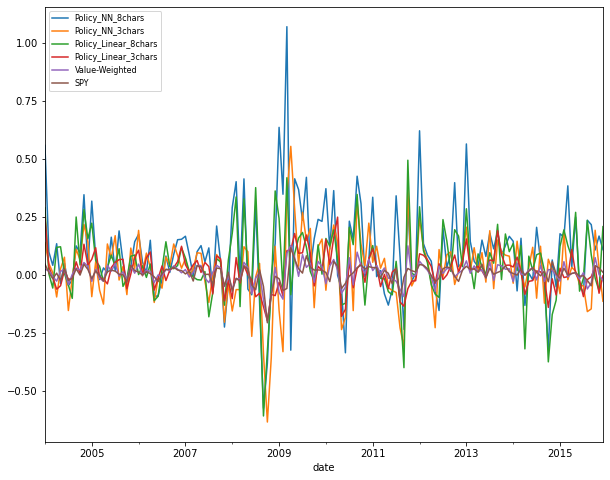

In [92]:
# plot out return performance realtive to SP500
plot = rtn_p.plot(x='date',y=['Policy_NN_8chars','Policy_NN_3chars','Policy_Linear_8chars','Policy_Linear_3chars','Value-Weighted','SPY'],figsize=(10, 8))
plot.legend(loc=2, prop={'size': 8})
plot